In [103]:
import json

from torch.nn.quantized.functional import threshold

with open('../data/output/full_match_binary/detection_raw.json') as f:
    d = json.load(f)    

In [104]:
pred_segs = []
segs = d["results"]["ginting_axelsen"]
for seg in segs:
    pred_segs.append({"start": seg["segment"][0], "end": seg["segment"][1], "score": seg["score"]})

In [105]:
import pandas as pd

df = pd.DataFrame(pred_segs)
df

,start,end,score
0,16.952456,19.429579,0.495929
1,19.964354,21.095312,0.022470
2,3.782256,4.837425,0.012727
3,13.147326,14.319829,0.005848
4,22.304107,23.523606,0.022908
...,...,...,...
763,3669.414343,3670.638514,0.004158
764,3679.455417,3680.509092,0.028643
765,3670.453278,3671.438313,0.012330
766,3687.867078,3688.946048,0.011876


In [106]:
threshold = 0.6
df = df[df['score'] > threshold]

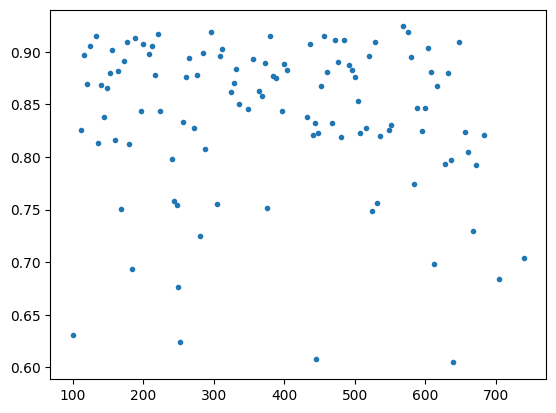

In [107]:
import matplotlib.pyplot as plt
plt.plot(df['score'], ".")

In [108]:
df = df.reset_index()
def ss_to_hhmmss(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02}:{minutes:02}:{seconds:02}"
merged_intervals = []

# Start with the first interval
current_start = df['start'].values[0]
current_end = df['end'].values[0]

# Iterate through the DataFrame rows
for i in range(1, len(df)):
    row_start = df.loc[i, 'start']
    row_end = df.loc[i, 'end']

    # If the current interval overlaps with the previous one, merge them
    if row_start <= current_end:
        current_end = max(current_end, row_end)  # Update the end of the merged interval
    else:
        # No overlap, add the previous interval and start a new one
        merged_intervals.append([current_start, current_end])
        current_start = row_start
        current_end = row_end

# Append the last interval
merged_intervals.append([current_start, current_end])

# Create a new DataFrame from the merged intervals
merged_df = pd.DataFrame(merged_intervals, columns=['start', 'end'])
merged_df = merged_df.assign(start_hhmmss=merged_df['start'].apply(ss_to_hhmmss))
merged_df = merged_df.assign(end_hhmmss=merged_df['end'].apply(ss_to_hhmmss))
merged_df

,start,end,start_hhmmss,end_hhmmss
0,499.886806,502.648100,00:08:19,00:08:22
1,546.038048,569.220135,00:09:06,00:09:29
2,585.483085,590.954463,00:09:45,00:09:50
3,602.695070,616.894206,00:10:02,00:10:16
4,637.038792,645.463597,00:10:37,00:10:45
...,...,...,...,...
79,3173.486856,3176.386063,00:52:53,00:52:56
80,3226.936325,3229.509701,00:53:46,00:53:49
81,3295.463389,3298.604160,00:54:55,00:54:58
82,3393.999232,3395.948022,00:56:33,00:56:35


In [109]:
merged_df.to_csv('./data/ginting_axelsen_hauptprojekt_full_match_binary.csv', index=False)

In [110]:
merged_df[['start_hhmmss', 'end_hhmmss']].to_csv('./trimming/clips.csv', index=False)